In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Path to dataset files:", path)

/home/mohsinkhan/.local/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|█████████████████████████████████████████████████████████████████| 219M/219M [00:59<00:00, 3.84MB/s]

Extracting files...


Path to dataset files: /home/mohsinkhan/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1


In [5]:
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [6]:
import torch
from torch import nn

In [7]:
from pathlib import Path

path = Path("/home/mohsinkhan/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset")
os.listdir(path)

['Arborio',
 'Basmati',
 'Ipsala',
 'Jasmine',
 'Karacadag',
 'Rice_Citation_Request.txt']

In [8]:
def walk_throght_dir(target_dir):
    for root, dirs, files in os.walk(target_dir):
        print(f"current directory : {root}")
        print(f"Subdirectory : {len(dirs)}")
        print(f"file {len(files)}")
walk_throght_dir(path)

current directory : /home/mohsinkhan/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset
Subdirectory : 5
file 1
current directory : /home/mohsinkhan/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Arborio
Subdirectory : 0
file 15000
current directory : /home/mohsinkhan/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Basmati
Subdirectory : 0
file 15000
current directory : /home/mohsinkhan/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Ipsala
Subdirectory : 0
file 15000
current directory : /home/mohsinkhan/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Jasmine
Subdirectory : 0
file 15000
current directory : /home/mohsinkhan/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Karacadag
Subdirectory : 0
file 15000


In [9]:
path

PosixPath('/home/mohsinkhan/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset')

In [10]:
import random
import PIL

def view_image(path):
    # image path list
    image_path_list = list(path.rglob("*.jpg"))
    
    # chose a random image
    random_image = random.choice(image_path_list) 
    
    # class name
    image_class_name = random_image.parent.stem
    
    img = PIL.Image.open(random_image)
    
    # let's see image
    print(f"image path {random_image}")
    print(f"image hight {img.height}")
    print(f"image width {img.width}")
    print(f"image class {image_class_name}\n")
    return img, image_class_name

img, image_class_name = view_image(path)

image path /home/mohsinkhan/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Ipsala/Ipsala (71).jpg
image hight 250
image width 250
image class Ipsala



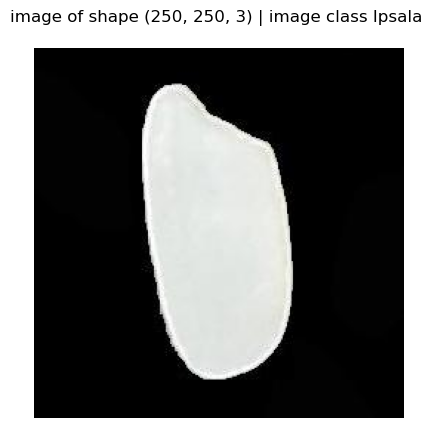

In [11]:
# convert image into an array and then visualize it 
image_as_array = np.asarray(img)
plt.imshow(image_as_array)
plt.title(f"image of shape {image_as_array.shape} | image class {image_class_name} \n")
plt.axis(False)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

image_paths = list(path.rglob("*.jpg"))
labels = [p.parent.stem for p in image_paths]

train_paths, test_paths = train_test_split(
    image_paths,
    test_size=0.2,
    stratify=labels,
    random_state=42
)


In [13]:
len(train_paths), len(test_paths)

(60000, 15000)

image path /home/mohsinkhan/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Basmati/basmati (2036).jpg
image hight 250
image width 250
image class Basmati



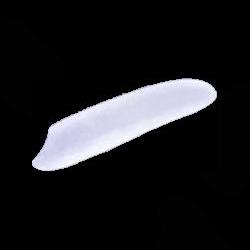

In [14]:

def view_image(path):
    # image path list
    # image_path_list = list(path.rglob("*.jpg"))
    
    # chose a random image
    random_image = random.choice(path) 
    
    # class name
    image_class_name = random_image.parent.stem
    
    img = PIL.Image.open(random_image)
    
    # let's see image
    print(f"image path {random_image}")
    print(f"image hight {img.height}")
    print(f"image width {img.width}")
    print(f"image class {image_class_name}\n")
    return img, image_class_name

img, image_class_name = view_image(train_paths)
img

In [15]:
# we can't use imagefolder here since it needs a clear structure of directory, and we don't have that,t  we are using paths
# let's create labels
classes =  sorted(set(labels))
# give them their index as label
class_to_idx  = {cls:idx for idx, cls in enumerate(classes)}
class_to_idx

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}

In [16]:
# create a castum dateset
from torch.utils.data import Dataset

class RiceDataset(Dataset):
    def __init__(self, image_path, class_to_idx, transform=None):
        self.image_path =  image_path
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        # loading  image
        img_path = self.image_path[idx]
        image = PIL.Image.open(img_path).convert("RGB")

        label_name = img_path.parent.stem
        label =  self.class_to_idx[label_name]

        if self.transform:
            image =  self.transform(image)
        return image, label


In [17]:
import cv2
import numpy as np
from PIL import Image

class CropRice:
    def __call__(self, img):
        img = np.array(img)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
        coords = cv2.findNonZero(thresh)

        x, y, w, h = cv2.boundingRect(coords)
        cropped = img[y:y+h, x:x+w]

        return Image.fromarray(cropped)


In [18]:
# defining transforms 

from torchvision import transforms
train_transform = transforms.Compose([
    CropRice(),                        
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    CropRice(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [19]:
train_data = RiceDataset(train_paths, class_to_idx, transform=train_transform)
test_data = RiceDataset(test_paths, class_to_idx, transform=test_transform)

In [20]:
train_data.class_to_idx

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}

In [21]:
len(train_data), len(test_data)

(60000, 15000)

In [22]:
def display_random_images(dataset:torch.utils.dataset.Dataset,
                         classes: List[str]=None,
                         n:int=10, 
                         display_shape:bool =True,
                         seed:int =None):
    # adjust display if n is too high:
    if n > 10:
        n=10
        print(f"n is adjusted to 10......")

    # set the random seed
    if seed:
        random.seed(seed)

    # get random sample index
    random_sample_idx = random.sample(range(len(dataset)), k=n)
    
    # setup plot
    plt.figure(figsize=(16,8))

    # loop through the sample and display random samples
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        targ_image_adjust = targ_image.permute(1,2,0)
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f"class : {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape : {targ_image_adjust.shape}"
        plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


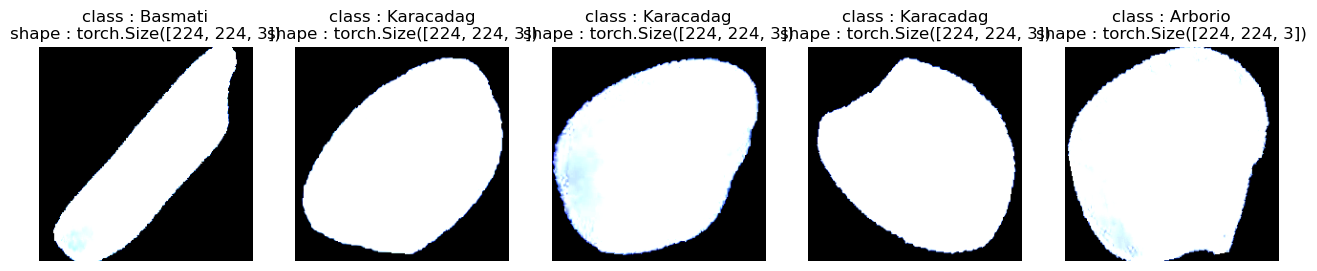

In [23]:
display_random_images(train_data,
                     classes, 
                     n=5)

In [24]:
# convert to datloader  of with batch_size=32
# import dataloader
from torch.utils.data import DataLoader

# define batch size
BATCH_SIZE=32 

train_dataloader = DataLoader(train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=0,
                             shuffle=True)


test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=0)

In [25]:
print(f"Number of training  batch {len(train_dataloader)} of batch size {BATCH_SIZE}")
print(f"Number of testing batch {len(test_dataloader)} of batch size {BATCH_SIZE}")


Number of training  batch 1875 of batch size 32
Number of testing batch 469 of batch size 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


shape eith batch size : torch.Size([32, 3, 224, 224]) label : torch.Size([32]) 


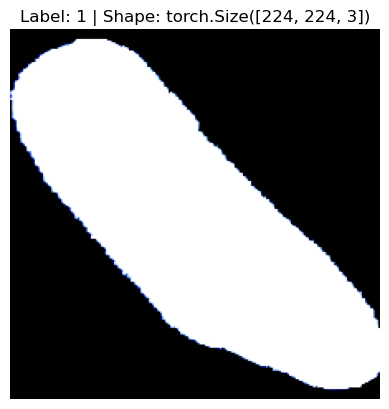

In [26]:
images, labels = next(iter(train_dataloader))

print(f"shape eith batch size : {images.shape} label : {labels.shape} ")
img = images[0]      
label = labels[0]     

# convert tensor (C,H,W) → (H,W,C)
img = img.permute(1, 2, 0)

plt.imshow(img)
plt.title(f"Label: {label} | Shape: {img.shape}")
plt.axis("off")
plt.show()

In [27]:
# set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [28]:
# let's build a model 

import torch.nn as nn

class RiceClassifier(nn.Module):
    def __init__(self, in_channels=3, num_classes=5):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 112×112

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 56×56

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 28×28
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # 🔥 removes hardcoding
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


model_0 = RiceClassifier().to(device)
model_0

RiceClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=128, out_features=5

In [29]:
from torchinfo import summary
summary(model_0, input_size=images.shape)

Layer (type:depth-idx)                   Output Shape              Param #
RiceClassifier                           [32, 5]                   --
├─Sequential: 1-1                        [32, 128, 28, 28]         --
│    └─Conv2d: 2-1                       [32, 32, 224, 224]        896
│    └─BatchNorm2d: 2-2                  [32, 32, 224, 224]        64
│    └─ReLU: 2-3                         [32, 32, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 32, 112, 112]        --
│    └─Conv2d: 2-5                       [32, 64, 112, 112]        18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 112, 112]        128
│    └─ReLU: 2-7                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-8                    [32, 64, 56, 56]          --
│    └─Conv2d: 2-9                       [32, 128, 56, 56]         73,856
│    └─BatchNorm2d: 2-10                 [32, 128, 56, 56]         256
│    └─ReLU: 2-11                        [32, 128, 56, 56]         --
│   

In [30]:
# now wehave model, we need to define a loss function, optimizer, and accuracy
from sklearn.metrics import accuracy_score

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.01)

In [31]:
def train_steps(model: nn.Module,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                dataloader: torch.utils.data.DataLoader,
                device=device):

    train_loss, train_acc = 0.0, 0.0

    # put model in training mode ONCE
    model.train()

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_logits = model(X)
        loss = loss_fn(y_logits, y)

        # Predictions
        y_pred = torch.argmax(y_logits, dim=1)

        # Accuracy (torch-based)
        acc = (y_pred == y).sum().item() / y.size(0)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        train_loss += loss.item()
        train_acc += acc

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [32]:
def test_steps(model: nn.Module,
               loss_fn: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               device=device):
    
    test_loss, test_acc = 0.0, 0.0
    model.eval()

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_logits = model(X)
            loss = loss_fn(y_logits, y)

            # Predictions
            y_pred = torch.argmax(y_logits, dim=1)

            # Accuracy
            acc = (y_pred == y).sum().item() / y.size(0)

            test_loss += loss.item()
            test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc


In [33]:
def train_model(model: nn.Module,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                epochs: int,
                device=device,
                patience: int = 4):

    results = {
        "train_loss": [],
        "test_loss": [],
        "train_acc": [],
        "test_acc": [],
        "epoch_count": []
    }

    best_test_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):

        trainloss, trainAcc = train_steps(
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            dataloader=train_dataloader,
            device=device
        )

        testloss, testAcc = test_steps(
            model=model,
            loss_fn=loss_fn,
            dataloader=test_dataloader,
            device=device
        )

        # Save results
        results["train_loss"].append(trainloss)
        results["train_acc"].append(trainAcc)
        results["test_loss"].append(testloss)
        results["test_acc"].append(testAcc)
        results["epoch_count"].append(epoch)

        print(f"Epoch: {epoch}/{epochs}")
        print(f"Train Loss: {trainloss:.4f} | Train Acc: {trainAcc:.4f}")
        print(f"Test  Loss: {testloss:.4f} | Test  Acc: {testAcc:.4f}")
        print("-" * 50)

        # Early stopping based on validation loss
        if testloss < best_test_loss:
            best_test_loss = testloss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

    return results


In [45]:
retults = train_model(model_0,
           loss_fn=loss_fn,
           optimizer=optimizer,
           train_dataloader=train_dataloader,
           test_dataloader=test_dataloader,
           epochs=5,
           )

Epoch: 1/5
Train Loss: 0.3364 | Train Acc: 0.8787
Test  Loss: 0.3463 | Test  Acc: 0.8820
--------------------------------------------------
Epoch: 2/5
Train Loss: 0.1647 | Train Acc: 0.9435
Test  Loss: 5.4713 | Test  Acc: 0.2376
--------------------------------------------------
No improvement for 1 epoch(s)
Epoch: 3/5
Train Loss: 0.0990 | Train Acc: 0.9663
Test  Loss: 0.2984 | Test  Acc: 0.8815
--------------------------------------------------
Epoch: 4/5
Train Loss: 0.0699 | Train Acc: 0.9777
Test  Loss: 0.1453 | Test  Acc: 0.9473
--------------------------------------------------
Epoch: 5/5
Train Loss: 0.0550 | Train Acc: 0.9819
Test  Loss: 0.2163 | Test  Acc: 0.9270
--------------------------------------------------
No improvement for 1 epoch(s)


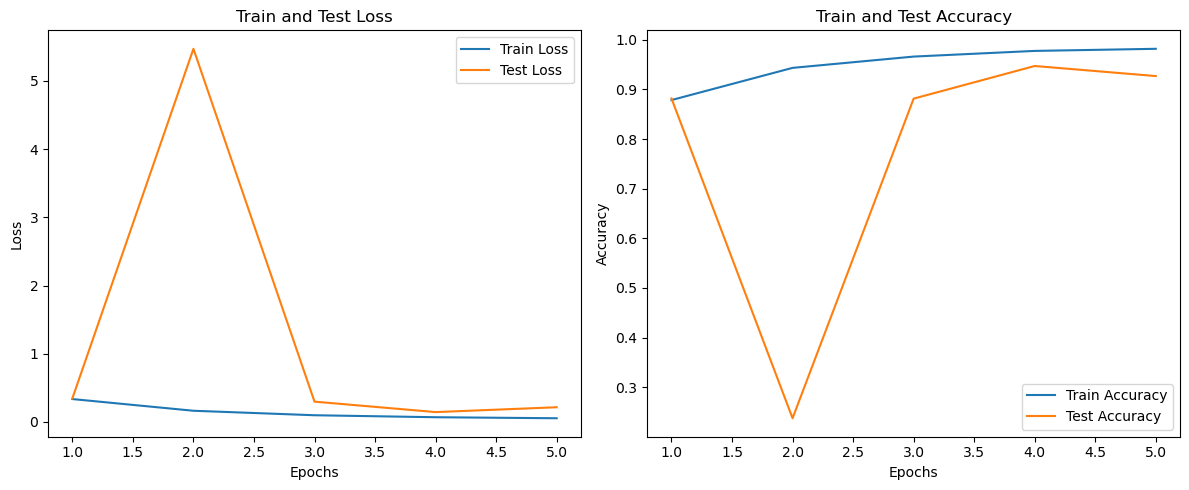

In [47]:
plt.figure(figsize=(12, 5))

# loss plot
plt.subplot(1, 2, 1)
plt.plot(retults["epoch_count"], retults["train_loss"], label="Train Loss")
plt.plot(retults["epoch_count"], retults["test_loss"], label="Test Loss")
plt.title("Train and Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# accuracy plot
plt.subplot(1, 2, 2)
plt.plot(retults["epoch_count"], retults["train_acc"], label="Train Accuracy")
plt.plot(retults["epoch_count"], retults["test_acc"], label="Test Accuracy")
plt.title("Train and Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                exist_ok=True)
MODEL_NAME="model_0"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

print(f"Saving model tp {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict,
          )

Saving model tp models/model_0


TypeError: save() missing 1 required positional argument: 'f'

In [41]:
# load the model 
MODEL_SAVE_PATH ="models/model_0.pth"
model_0.load_state_dict(torch.load(MODEL_SAVE_PATH, weights_only=True))
model_0.eval()

RiceClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=128, out_features=5

In [43]:
import os
os.listdir("/home/mohsinkhan/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset")

['Arborio',
 'Basmati',
 'Ipsala',
 'Jasmine',
 'Karacadag',
 'Rice_Citation_Request.txt']